<a href="https://colab.research.google.com/github/Mainakdeb/project-nova/blob/main/classify_supernova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install iterative-stratification

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [121]:
!cp /content/drive/MyDrive/mydata/ext_small_images2.zip /content/

In [4]:
!cp -r /content/drive/MyDrive/mydata/ext_sm_all.csv /content/

In [170]:
!unzip /content/ext_small_images2.zip

Archive:  /content/ext_small_images2.zip
replace ext_small_images/ext_sm_9544888.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from albumentations import *
import cv2
import numpy as np
from tqdm.notebook import tnrange, tqdm
from IPython.display import clear_output

import torch
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [173]:
df= pd.read_csv('ext_sm_all.csv')
df.head()

,Unnamed: 0,images,targets,file_paths,observation_numbers
0,0,[[[255 56 41 ... 60 53 255]\n [ 90 255 6...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713492
1,1,[[[255 81 120 ... 48 101 255]\n [ 68 255 10...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713475
2,2,[[[255 42 9 ... 14 43 255]\n [ 18 255 1...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713459
3,3,[[[255 28 31 ... 35 55 255]\n [ 40 255 5...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713470
4,4,[[[255 2 0 ... 4 3 255]\n [ 4 255 ...,1,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713469


In [174]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [165]:
def image_to_nparray(path):
    i = cv2.imread(path)
    #i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [175]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'0':0,
                           '1':1,
                           }
        
    def __getitem__(self, idx): 

        smol_img_path = "ext_sm_"+ str(self.d.iloc[idx]['observation_numbers'])+".png" #image path column
        #print(smol_img_path )
        class_name = str(self.d.iloc[idx]['targets'])  #class name column
        full_img_path = self.root_dir + smol_img_path #+ '.png'

        '''
        img_arr range is 0, 255, so divided by 255.
        '''
        #img_arr = (image_to_nparray(full_img_path)/255.).astype(np.float32)
        img_arr=image_to_nparray(full_img_path)
        #print(img_arr.max(), img_arr.min())

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }

    def __len__(self):
        return (len(self.d))

In [176]:
data = C_Dataset(pd.read_csv("/content/ext_sm_all.csv", ), 
                 '/content/ext_small_images/',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                # transforms.ToPILImage(),
                                                #transforms.Resize((224,224)),
                                                #transforms.CenterCrop((128,128)),
                                                transforms.ToTensor()
                                                ])
                )

train_dl = torch.utils.data.DataLoader(data,
                                       batch_size=64,
                                       shuffle=True,
                                       #pin_memory=True,
                                       #num_workers=4
                                    )

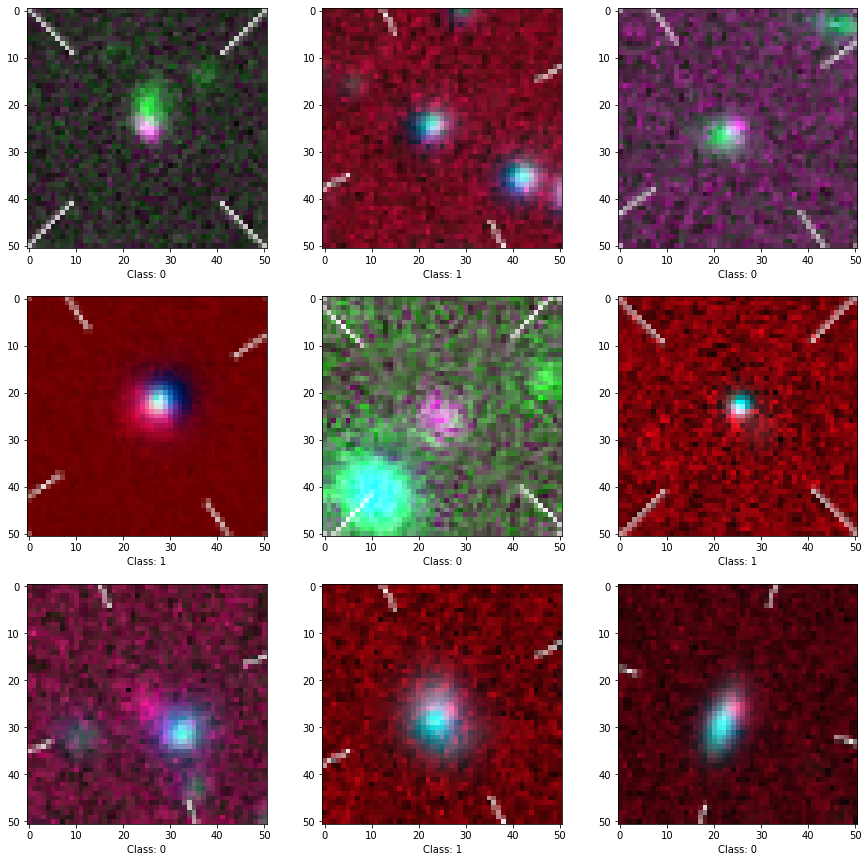

In [177]:
fig, ax = plt.subplots(3,3, figsize = (15,15))
class_dict = {'0':0,
              '1': 1
              }

for i in range (9):
  batch = next(iter(train_dl))
  image, label=batch['x'],batch['y']
  #print(label)
  ax.flat[i].imshow(image[0].permute(1,2,0))
  
  text = "Class: "+list(class_dict.keys())[int(label[0])]
  ax.flat[i].set_xlabel(text)

In [178]:
def create_folds_from_csv(input_csv_path, output_csv_path):
  #create folds
  df = pd.read_csv(input_csv_path)
  df.loc[:,"kfold"] = -1
  targets = df.drop('targets', axis=1).values

  NFOLDS = 10
  mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
  for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
      df.loc[val, "kfold"] = fold
      
  df.to_csv("./train_targets_folds.csv", index=False)

def balance_df(df, cls):
  max_size = df[cls].value_counts().max()
  lst = [df]
  for class_index, group in df.groupby(cls):
      lst.append(group.sample(max_size-len(group), replace=True))
  frame_new = pd.concat(lst)
  df2=frame_new
  return(df2)


In [182]:
# balanced_df=balance_df(pd.read_csv('/content/ext_sm_all.csv'),
#                        'targets')
# balanced_df.to_csv('balanced_data.csv')
# print(balanced_df['targets'].value_counts())


create_folds_from_csv(input_csv_path='/content/ext_sm_all.csv',
                      output_csv_path='./train_targets_folds.csv')

In [183]:
d=pd.read_csv('balanced_data.csv')
d.head()

,Unnamed: 0,Unnamed: 0.1,images,targets,file_paths,observation_numbers
0,0,0,[[[255 56 41 ... 60 53 255]\n [ 90 255 6...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713492
1,1,1,[[[255 81 120 ... 48 101 255]\n [ 68 255 10...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713475
2,2,2,[[[255 42 9 ... 14 43 255]\n [ 18 255 1...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713459
3,3,3,[[[255 28 31 ... 35 55 255]\n [ 40 255 5...,0,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713470
4,4,4,[[[255 2 0 ... 4 3 255]\n [ 4 255 ...,1,/home/ubuntu/notebooks/data/home2/SNWG/Archive...,10713469


In [220]:
class Engine:
      def __init__(self, model, optimizer, device, scheduler, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion=criterion

      def train(self, data_loader):
        train_loss = 0.0
        valid_loss = 0.0
        total_tr = 0.0
        correct_tr = 0.0
        self.model.train()
        for batch in tqdm(data_loader, desc="training"):##
          data, target=batch['x'].to(self.device), batch['y'].to(self.device)
          self.optimizer.zero_grad()
          # Forward Pass
          output = self.model(data)
          loss = self.criterion(output, target)
          # Backward Pass  
          loss.backward()
          # Update loss and accuracy
          self.optimizer.step()
          train_loss += loss.item() * data.size(0)
          _,predicted = torch.max(output.data, 1)
          total_tr += target.size(0)
          correct_tr += (predicted == target).sum().item()
        #self.scheduler.step(1.)
        return(train_loss/len(data_loader.sampler), 100*correct_tr/total_tr)

      def evaluate(self, data_loader):
        valid_loss = 0.0
        total_val=0.0
        correct_val=0.0
        self.model.eval()
        for data in data_loader:
            data, target=batch['x'].to(self.device), batch['y'].to(self.device)
            output = self.model(data)
            loss = self.criterion(output, target)
            valid_loss += loss.item()* data.size(0)
            _,predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
        return(valid_loss/len(data_loader.sampler), 100*correct_val/total_val)


In [225]:
def run_training(load_pretrained, pretrained_path, fold, batch_size, lr, save_model=True, num_epochs = 1, plot_metrics=True):

    train_csv=pd.read_csv('./train_targets_folds.csv')
    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    train_dataset = C_Dataset(train_fold, 
                 '/content/ext_small_images/',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=300, interpolation=1, border_mode=4, always_apply=True, p=0.9),
                                        HorizontalFlip(p=0.5),
                                        VerticalFlip(p=0.5)  
                                        ]),
                transform = transforms.Compose([    
                                                # transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                #transforms.CenterCrop((32,32)),
                                                # transforms.RandomHorizontalFlip(), 
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                ])
                )
    valid_dataset = C_Dataset(val_fold, 
                 '/content/ext_small_images/',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                # transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                # transforms.RandomHorizontalFlip(), 
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

                                                ])
                )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size,
                    shuffle=True
                )
    val_loader = torch.utils.data.DataLoader(
                    valid_dataset,
                    batch_size=128,
                    shuffle=True
                )

    torch.cuda.empty_cache()
    model_ft = models.resnet18(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(
        nn.Dropout(0.65),
        nn.Softmax(),
        nn.Linear(num_ftrs, 2))
    model = model_ft.to(device)

    if load_pretrained:
        model.load_state_dict(torch.load(pretrained_path))
        print("model loaded successfully: ", pretrained_path)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.00001)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1,
                                                 patience=5, 
                                                 eps=1e-4, 
                                                 verbose=True)
    eng = Engine(model,
                 optimizer, 
                 device='cuda', 
                 scheduler = scheduler,
                 criterion=criterion)
    
    best_loss = 999
    early_stop_iter = 10
    early_stop_count=0
    train_losses_arr=[]
    train_acc_arr=[]
    val_losses_arr=[]
    val_acc_arr=[]

    for epoch in range(num_epochs):
        train_loss, train_accuracy = eng.train(train_loader)
        valid_loss, valid_accuracy = eng.evaluate(val_loader)
        
        train_losses_arr.append(train_loss)
        val_losses_arr.append(valid_loss)
        train_acc_arr.append(train_accuracy)
        val_acc_arr.append(valid_accuracy)

        #print("epoch:{:.0f} train_loss: {:.3f} valid_loss: {:.3f} train_acc: {:.3f} valid_acc{:.3f}".format(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))#, "val_loss:", valid_loss)
        
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break

        if plot_metrics:
            clear_output(wait=True)
            print("fold {:.0f} epoch:{:.0f} train_loss: {:.3f} valid_loss: {:.3f} train_acc: {:.3f}% valid_acc: {:.3f}%".format(fold+1, epoch+1, train_loss, valid_loss, train_accuracy, valid_accuracy))#, "val_loss:", valid_loss)
            
            plt.plot(train_losses_arr, 'r',label="train_loss")
            plt.plot(val_losses_arr, 'g',label="valid_loss")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

            plt.plot(train_acc_arr, 'r',label="train_accuracy")
            plt.plot(val_acc_arr, 'g',label="valid_accuracy")
            plt.xlabel("iterations")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

    torch.save(model.state_dict(), "model_final.pth")                
    return(best_loss)

fold 1 epoch:20 train_loss: 0.137 valid_loss: 0.265 train_acc: 96.233% valid_acc: 76.562%


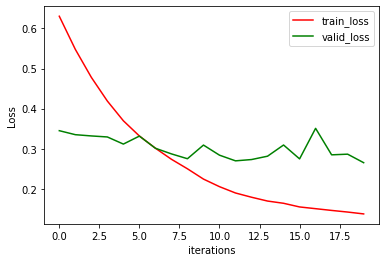

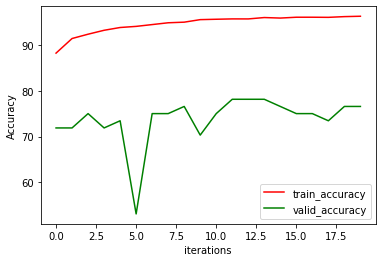

In [227]:
best_losses = []
NFOLDS=1
#train one fold
for fold in range(NFOLDS):
    best_losses.append(
        run_training(
            load_pretrained=False,
            pretrained_path="",
            fold=fold,
            batch_size = 350, #best_params["batch_size"],
            lr = 0.0005, #best_params["lr"], 0.00014148226882681195
            num_epochs = 30,
            plot_metrics=True
        )
    )

In [229]:
!cp /content/model_final.pth /content/drive/MyDrive/mydata/nova_res18_76.pth